In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# .ensemble 메서드는 앙상블 학습 위주
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import( 
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split # .model_seclection 메서드는 모델의 성능 평가와 하이퍼파라미터튜닝
from tqdm import tqdm # 진행바 표시 라이브러리

## 데이터 로드

In [2]:
# 2. 데이터 불러오기
df = pd.read_csv('C:/Users/taeyo/OneDrive/바탕 화면/DA Final/preprocessing_data.csv', dtype={'isbn': str})
keyword_best = pd.read_csv('C:/Users/taeyo/OneDrive/바탕 화면/DA Final/mecab keyword(베스트).csv', dtype={'isbn': str})
keyword_book = pd.read_csv('C:/Users/taeyo/OneDrive/바탕 화면/DA Final/mecab keyword(일반).csv', dtype={'isbn': str})

In [3]:

keyword_book.info()
keyword_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   topic_0  627 non-null    float64
 1   topic_1  627 non-null    float64
 2   topic_2  627 non-null    float64
 3   topic_3  627 non-null    float64
 4   topic_4  627 non-null    float64
 5   topic_5  627 non-null    float64
 6   isbn     627 non-null    object 
dtypes: float64(6), object(1)
memory usage: 34.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   topic_0  627 non-null    float64
 1   topic_1  627 non-null    float64
 2   topic_2  627 non-null    float64
 3   topic_3  627 non-null    float64
 4   topic_4  627 non-null    float64
 5   topic_5  627 non-null    float64
 6   isbn     627 non-null    object 
dtypes: float64(6), object(1)
memory usage: 34.4+ KB


In [4]:
# 3. 베스트/일반 도서 분리 및 키워드 병합
df_best = df[df['label'] == 1].copy()
df_book = df[df['label'] == 0].copy()

df_best = df_best.merge(keyword_best, on='isbn', how='left')
df_book = df_book.merge(keyword_book, on='isbn', how='left')

df = pd.concat([df_best, df_book], ignore_index=True)

In [5]:
#for i in range(6):
#     df[f'topic_{i}'] = df[f'topic_{i}'].fillna(0)

# # 확인
#df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].isnull().sum()

In [6]:
# 1. 필요한 topic 컬럼 이름
topic_cols = [f'topic_{i}' for i in range(6)]

# 2. topic 결측 제거
df_filtered = df.dropna(subset=topic_cols)

for col in df_filtered.columns:
    print(col)

print(df_filtered.shape)  # → (1627, XX

isbn
title
publishDate
price
pageCount
size
weight
rating
shortReviewCount
fullReviewCount
label
shortReview_present
fullReview_present
author_name_tf
publisher_name_tf
topic_0
topic_1
topic_2
topic_3
topic_4
topic_5
(1627, 21)


In [7]:
# 4. feature 및 label 분리
# title, isbn, label 제거 / 리뷰 관련 칼럼도 제거 가능 (선택)
drop_cols = [
    'isbn', 'title', 'label',
    'rating', 'shortReviewCount', 'fullReviewCount',
    'shortReview_present', 'fullReview_present'
]
X = df.drop(columns=drop_cols, errors='ignore')
y = df['label']

In [8]:
df = pd.concat([df_best, df_book], ignore_index=True)
print(df.shape)

df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].head()

(3316, 21)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.005781,0.003096,0.006070,0.005778,0.004806,0.974469
1,0.000781,0.644215,0.000820,0.151553,0.202110,0.000523
2,0.000660,0.000353,0.000693,0.706756,0.000548,0.290990
3,0.001478,0.993275,0.001552,0.001477,0.001229,0.000990
4,0.001208,0.000647,0.674994,0.321337,0.001004,0.000809


## RF 학습

In [9]:
# 5. 데이터 분할 (train 70%, val 20%, test 10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

# 크기 확인
X_train.shape, X_val.shape, X_test.shape

((2321, 13), (663, 13), (332, 13))

In [10]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ 기본 Random Forest 모델 (baseline)
basic_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
basic_rf.fit(X_train, y_train)
y_val_pred_basic = basic_rf.predict(X_val)

results = []
results.append({
    'name': 'RF_baseline',
    'model': basic_rf,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_basic),
    'report': classification_report(y_val, y_val_pred_basic, output_dict=False)
})

# 2️⃣ Optuna 목적 함수 정의 (Random Forest 하이퍼파라미터 탐색)
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# 3️⃣ 베이지안 최적화 실행
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100, show_progress_bar=True)

# 4️⃣ 최적 파라미터로 재학습 및 결과 저장
best_rf_params = study_rf.best_trial.params
best_rf_model = RandomForestClassifier(**best_rf_params)
best_rf_model.fit(X_train, y_train)
y_val_pred_tuned = best_rf_model.predict(X_val)

results.append({
    'name': 'RF_optuna',
    'model': best_rf_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_tuned),
    'report': classification_report(y_val, y_val_pred_tuned, output_dict=False),
    'best_params': best_rf_params
})

# 5️⃣ 결과 출력
for res in results:
    print(f"\n==== {res['name']} ====")
    print(res['conf_matrix'])
    print(res['report'])
    if 'best_params' in res:
        print("Best Params:", res['best_params'])

[I 2025-06-08 00:05:21,231] A new study created in memory with name: no-name-c433f385-1ea8-45fa-884b-f872c887be45


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-08 00:05:21,995] Trial 0 finished with value: 0.9532428355957768 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.9532428355957768.
[I 2025-06-08 00:05:23,615] Trial 1 finished with value: 0.9592760180995475 and parameters: {'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.9592760180995475.
[I 2025-06-08 00:05:26,131] Trial 2 finished with value: 0.9638009049773756 and parameters: {'n_estimators': 900, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9638009049773756.
[I 2025-06-08 00:05:28,300] Trial 3 finished with value: 0.9532428355957768 and parameters: {'n_estimators': 700, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9638009049773756.

In [11]:
# 7. 검증 성능 확인
print("📊 Validation Set Results")
y_val_pred = best_rf_model.predict(X_val)
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=4))

📊 Validation Set Results
[[450  13]
 [ 12 188]]
              precision    recall  f1-score   support

           0     0.9740    0.9719    0.9730       463
           1     0.9353    0.9400    0.9377       200

    accuracy                         0.9623       663
   macro avg     0.9547    0.9560    0.9553       663
weighted avg     0.9624    0.9623    0.9623       663



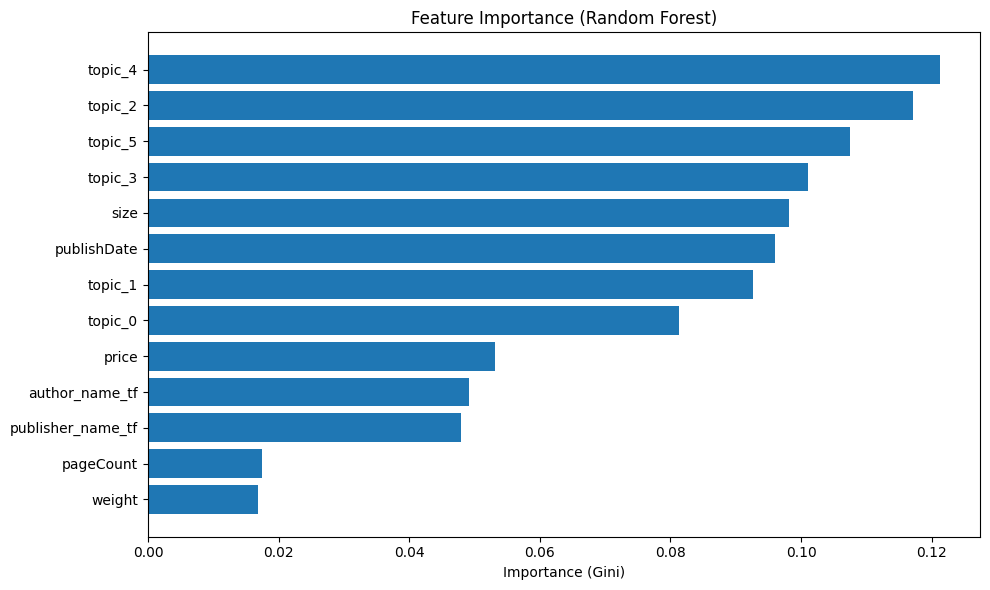

In [12]:
import matplotlib.pyplot as plt

# Random Forest 모델의 feature importance 사용
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# 중요도 기준 정렬 (상위 20개)
sorted_idx = importances.argsort()[::-1][:20]
top_features = feature_names[sorted_idx]
top_importances = importances[sorted_idx]

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(top_features)), top_importances[::-1])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features[::-1])
ax.set_title("Feature Importance (Random Forest)")
ax.set_xlabel("Importance (Gini)")
plt.tight_layout()
plt.show()

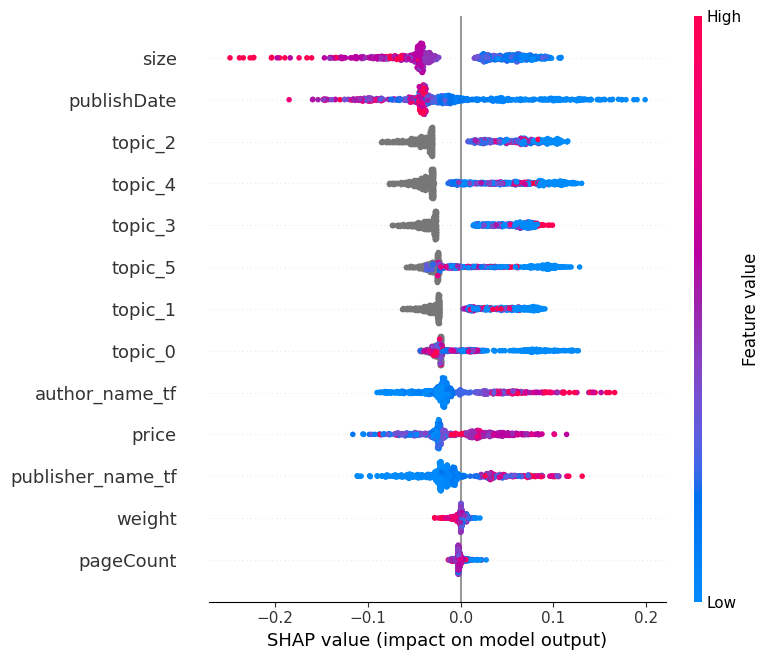

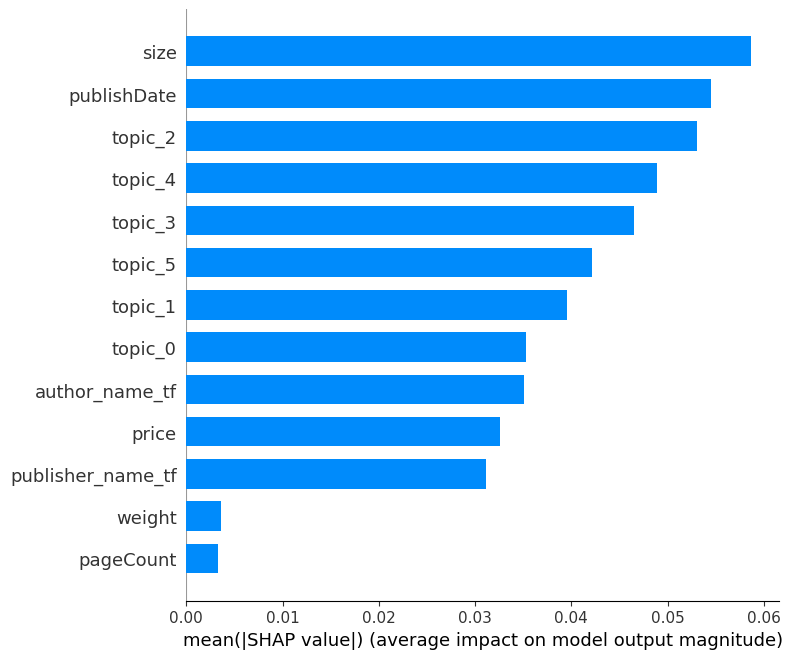

In [13]:
import shap

# 1. SHAP 값 계산 (3차원 배열)
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_val)  # shape: (663, 13, 2)

# 2. 클래스 1(베스트셀러) SHAP 값 추출
shap_values_best = shap_values[:, :, 1]  # shape: (663, 13)

# 3. 시각화
shap.summary_plot(shap_values_best, X_val, feature_names=X_val.columns.tolist())
shap.summary_plot(shap_values_best, X_val, plot_type="bar", feature_names=X_val.columns.tolist())

In [14]:
print("Train Accuracy:", accuracy_score(y_train, best_rf_model.predict(X_train)))
print("Val Accuracy:", accuracy_score(y_val, best_rf_model.predict(X_val)))

Train Accuracy: 1.0
Val Accuracy: 0.9622926093514329
